In [ ]:
pip install scikit-learn-extra

In [ ]:
!pip install --quiet pyspark

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from __future__ import division
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.cluster import KMeans
input = "/content/gdrive/My Drive/Country-data.csv"

## Sequential K Means clustering

In [ ]:
class K_Means(object):
    def __init__(self, n_clusters, max_iter):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    # Function to assign points to a cluster
    def assign_points_to_cluster(self, X):
        self.labels_ = [self._nearest(self.cluster_centers_, x) for x in X]
        indices=[]
        for j in range(self.n_clusters):
            cluster=[]
            for i, l in enumerate(self.labels_):
                if l==j: cluster.append(i)
            indices.append(cluster)
        X_by_cluster = [X[i] for i in indices]
        return X_by_cluster

    # Function to randomly select initial centroids
    def initial_centroid(self, X):
        initial = np.random.permutation(X.shape[0])[:self.n_clusters]
        return X[initial]

    # Function to update centroids and repeat assign_points_to_cluster until convergence or max_iter is reached
    def fit(self, X):
        self.cluster_centers_ = self.initial_centroid(X)
        for i in range(self.max_iter):
            X_by_cluster = self.assign_points_to_cluster(X)
            # calculating the new centroids
            new_centers=[c.sum(axis=0)/len(c) for c in X_by_cluster]
            new_centers = [arr.tolist() for arr in new_centers]
            old_centers=self.cluster_centers_
            # if the new centroids are the same as the old centroids then the algorithm has converged
            if np.all(new_centers == old_centers):
                self.number_of_iter=i
                break;
            else:
                self.cluster_centers_ = new_centers
        self.number_of_iter=i
        return self

    # Function to calculate the minimum euclidean distance
    def _nearest(self, clusters, x):
        return np.argmin([self._distance(x, c) for c in clusters])

    # Function to calculate euclidean distance between two points
    def _distance(self, a, b):
        return np.sqrt(((a - b)**2).sum())

    # Function to return predicted cluster for each point
    def predict(self, X):
      return self.labels_

## Parallelized K Means Clustering

In [ ]:
from pyspark import SparkContext, SparkConf

In [ ]:
try:
    sc = SparkContext.getOrCreate()
except Exception as e:
    print("An error occurred while trying to create or get SparkContext:", str(e))
    sc = None

if sc is None:
    conf = SparkConf().setAppName("KMeansClustering").setMaster("local")
    sc = SparkContext(conf=conf)

ValueError: ignored

In [ ]:
import numpy as np

'''
Function to compute centroids for clusters in an RDD.
Returns an RDD of the structure: (cluster_id, [centroid_coordinates]).
  - points : rdd of iterables (n dimensions)
  - cluster_ids : rdd with the same number of samples as "points" that contains the ids of their clusters
'''
def compute_centroids(points, cluster_ids):
  # Creating an rdd containing elements with the strucuture : cluster_id, [point_f1, ... , point_fn]
  # fi : ith feature
  combined_rdd = cluster_ids.zip(points)

  # Calculating the sum of the points of each cluster
  # sum_by_cluster_id has the following structure : cluster_id, [cluster_sum_f1, ..., cluster_sum_fn]
  sum_by_cluster_id = combined_rdd.reduceByKey(lambda x,y : np.sum([x, y], axis=0))

  # Count the number of points in each cluster.
  # A third rdd : cluster_id, nb_elements_cluster
  count_by_cluster_id = combined_rdd.mapValues(lambda v: 1).reduceByKey(lambda x,y : x+y)

  # Compute the centroid for each cluster : [cluster_sum_f1, ..., cluster_sum_fn] / nb_elements_cluster
  # Returns an rdd with the structure : (cluster_id, [mean_x1, ..., mean_xn])
  # The vector represents the centroid of the cluster
  centroids_rdd = sum_by_cluster_id.join(count_by_cluster_id).mapValues(lambda x: x[0]/x[1])

  return centroids_rdd

In [ ]:
from numpy.linalg import norm
from scipy import spatial

'''
Computes the distance of each point to the different clusters given a certain metric
  - point_value : the point vector [point_f1, ..., point_fn]
  - clusters_centroids : [clusted_id, [cluster_f1, ..., clusted_fn]]
  - metric [optional] : Takes two values ('squared_distances' for the euclidean metric, 'cos_sim' for the consine_similarity)
'''
def compute_distance(point_value, clusters_centroids, metric='squared_distances'):
  comp_dist = []

  if metric=='cos_sim':
      for m in clusters_centroids:
          # m[0] : id of the cluster
          # m[1] : mean vector (centroid) of the cluster
          comp_dist.append(1 - spatial.distance.cosine(np.array(point_value), np.array(m[1])))
  else:
      for m in clusters_centroids:
          # m[0] : id of the cluster
          # m[1] : mean vector (centroid) of the cluster
          comp_dist.append(norm(np.array(point_value)-np.array(m[1])))

  return comp_dist

In [ ]:
'''
Assigns each point to the closest cluster
  - points : rdd of iterables (n dimensions)
  - centroids : rdd with elements of structure : clusted_id, [centroid_coordinate]
  - metric [optional] : Takes two values ('squared_distances' for the euclidean metric, 'cos_sim' for the consine_similarity)
  '''
def assign_clusters(points, centroids, metric='squared_distances'):

  # Collecting the centroids as a python list (from the nodes to the driver)
  list_centroids = centroids.collect()

  # Broadcasting the variable to access it from inside the map
  list_centroidsB = sc.broadcast(list_centroids)

  distances_rdd = points.map(lambda x: compute_distance(x, list_centroidsB.value, metric))

  assign_rdd = distances_rdd.map(lambda x : np.argmin(x, axis=0))
  return assign_rdd

In [ ]:
def initialize_kmeans(n_clusters, data, factor=10):
  nb_elements = n_clusters*factor
  sample = data.take(nb_elements)
  rdn_number = 0
  centroides = []

  for i in range(n_clusters):
    rdn_number = random.randint(0, len(sample)-1)
    centroides.append([i, sample[rdn_number]])
  return sc.parallelize(centroides)

In [ ]:
def custom_kmeans(n_clusters, data, factor=15, maxIter=1000, metric='squared_distances'):
  # Initialization
  centroides = initialize_kmeans(n_clusters, data, factor)

  stop = False
  i=0
  while stop==False and i<maxIter:
    assigned_clusters = assign_clusters(data, centroides, metric)
    new_centro = compute_centroids(data, assigned_clusters)
    if i==0:
        prev_centro_ram = pd.DataFrame([x[1] for x in centroides.collect()])
    else:
        prev_centro_ram = pd.DataFrame([x[1].tolist() for x in centroides.collect()])

    new_centro_ram = pd.DataFrame([x[1].tolist() for x in new_centro.collect()])
    if new_centro_ram.equals(prev_centro_ram):
      stop = True
    else:
      centroides = new_centro
      i+=1

  return new_centro, assigned_clusters

## Comparison

In [ ]:
data = pd.read_csv(input)

In [ ]:
del data['country']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   child_mort  167 non-null    float64
 1   exports     167 non-null    float64
 2   health      167 non-null    float64
 3   imports     167 non-null    float64
 4   income      167 non-null    int64  
 5   inflation   167 non-null    float64
 6   life_expec  167 non-null    float64
 7   total_fer   167 non-null    float64
 8   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 11.9 KB


In [ ]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [ ]:
data.columns

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

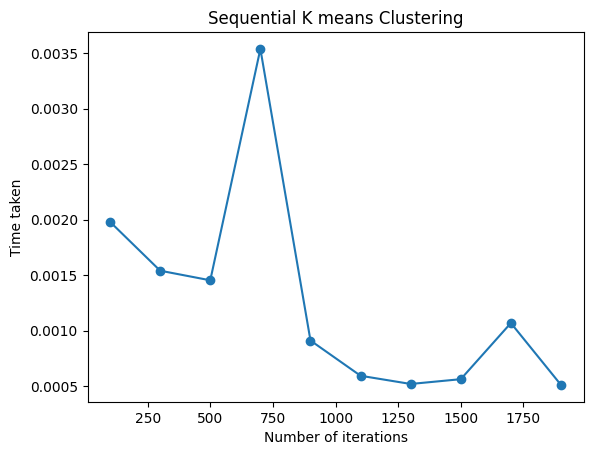

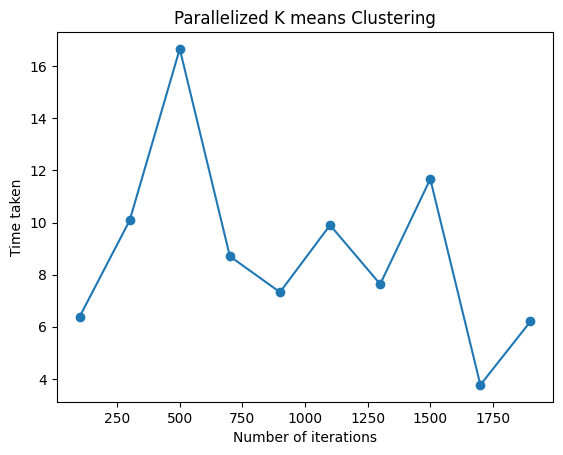

In [ ]:
X = data.to_numpy()[0:9]
itr = np.arange(100,2000,200)
t_ser = []
t_par = []

for i in itr:
  t1 = time.time()
  KmeansSer = K_Means(3,i)
  y = KmeansSer.fit(X)
  t2 = time.time() - t1
  t_ser.append(t2)

rdd = sc.parallelize(X)

for i in itr:
  t1 = time.time()
  new_centro, assigned_clusters = custom_kmeans(n_clusters = 3,data=rdd, maxIter=i)
  t2 = time.time() - t1
  t_par.append(t2)

plt.plot(itr,t_ser,'-o')
plt.title('Sequential K means Clustering')
plt.xlabel('Number of iterations')
plt.ylabel('Time taken')
plt.show()

plt.plot(itr,t_par,'-o')
plt.title('Parallelized K means Clustering')
plt.xlabel('Number of iterations')
plt.ylabel('Time taken')
plt.show()

In [ ]:
X = data.to_numpy()

t1 = time.time()
KmeansSer = K_Means(3,2500)
y = KmeansSer.fit(X)
t2 = time.time() - t1
data['Label_Seq'] = y.labels_

t3 = time.time()
rdd = sc.parallelize(X)
new_centro, assigned_clusters = custom_kmeans(n_clusters = 3,data=rdd, maxIter=2500)
t4 = time.time() - t3
data['Label_Par'] = assigned_clusters.collect()

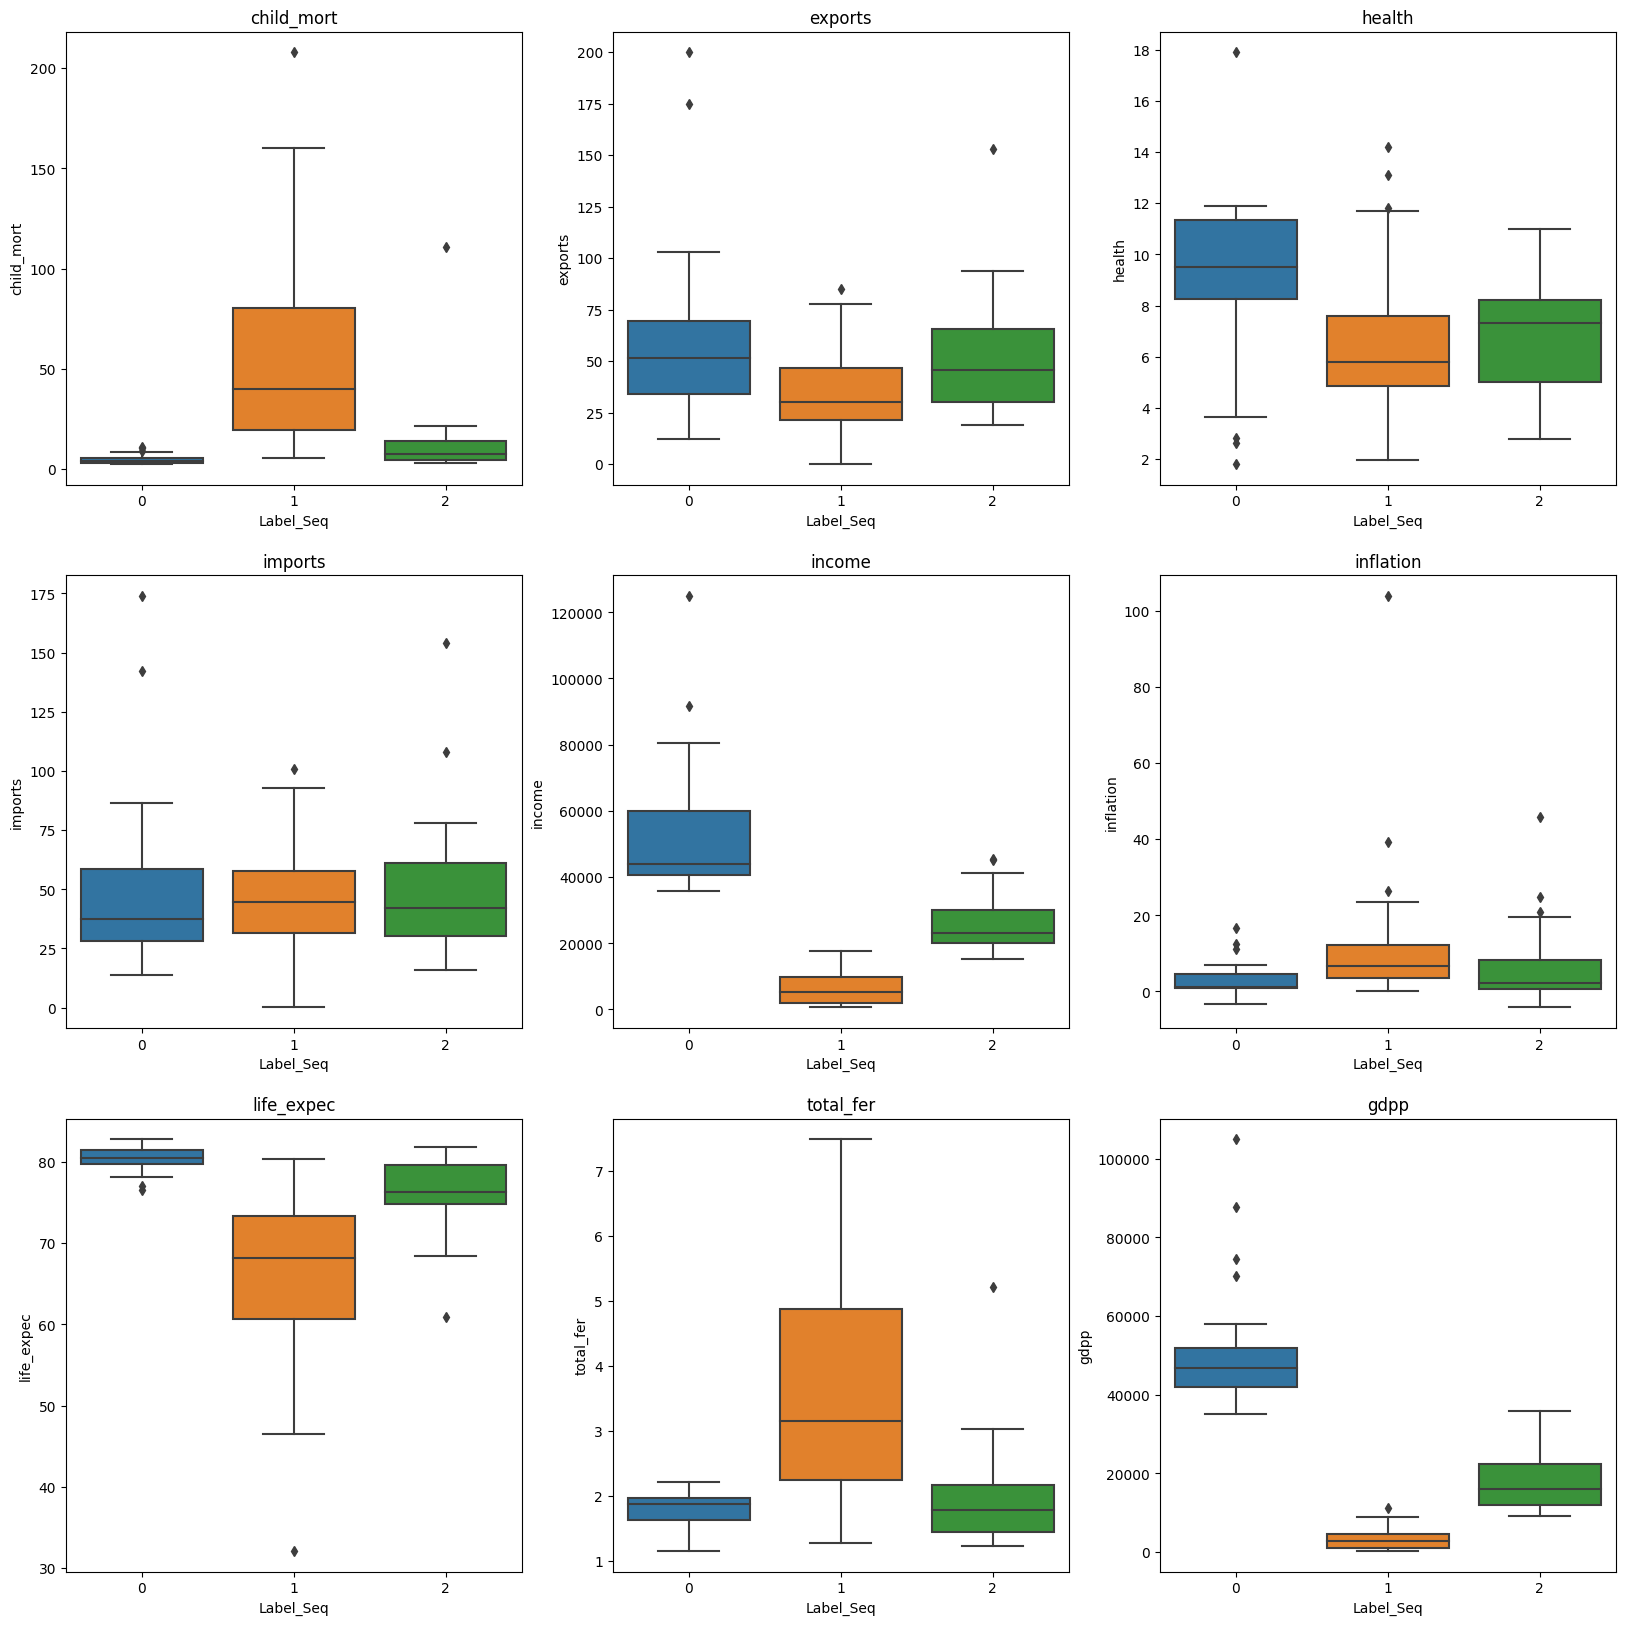

In [ ]:
l=['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
plt.figure(figsize=(20,20))
for i in range(len(l)):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=data['Label_Seq'],y=data[l[i]])
    plt.title(l[i])

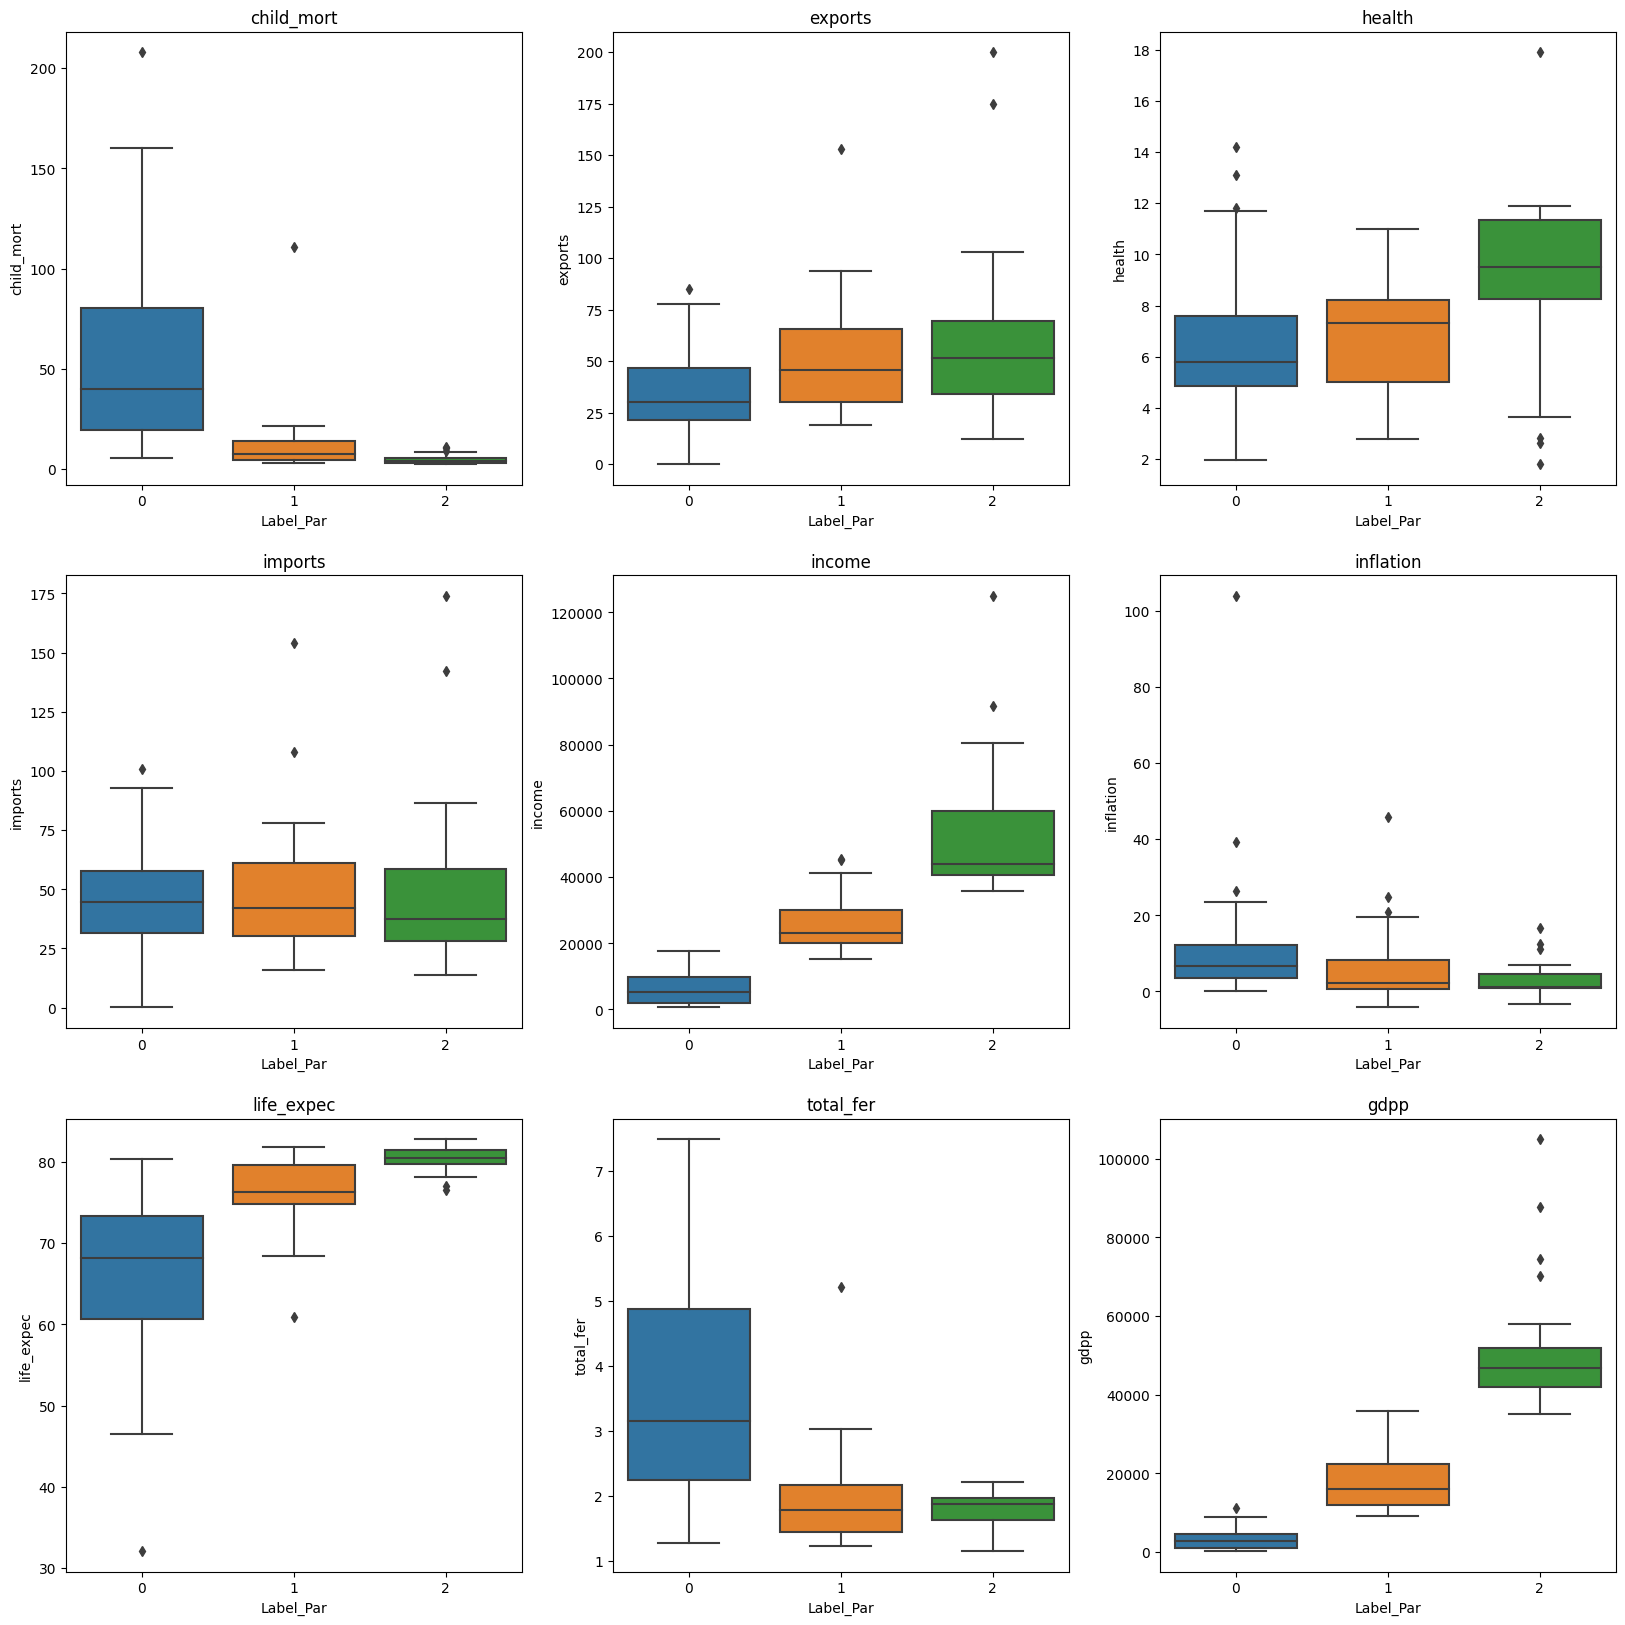

In [ ]:
l=['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
plt.figure(figsize=(20,20))
for i in range(len(l)):
    plt.subplot(3,3,i+1)
    sns.boxplot(x=data['Label_Par'],y=data[l[i]])
    plt.title(l[i])

In [ ]:
from sklearn import metrics

print("Performance of Sequential algorithm : ",metrics.silhouette_score(X,data['Label_Seq']))
print("Performance of Parallel algorithm : ",metrics.silhouette_score(X,data['Label_Par']))

Performance of Sequential algorithm :  0.6003679947620904
Performance of Parallel algorithm :  0.6003679947620904


## Clustering Analysis

In [ ]:
averages_of_all = pd.DataFrame(data.groupby('Label_Par').agg({'gdpp':'mean', 'income':'mean', 'inflation':'mean', 'exports':'mean', 'imports':'mean','health':'mean', 'child_mort':'mean', 'life_expec':'mean', 'total_fer':'mean'}))

display(averages_of_all.sort_values(by = ['child_mort', 'total_fer', 'health', 'life_expec', 'income'],ascending = [False, False, True, True, True]))

,gdpp,income,inflation,exports,imports,health,child_mort,life_expec,total_fer
Label_Par,,,,,,,,,
0,3074.990826,6485.899083,9.152055,33.251367,45.476751,6.314771,53.744037,66.632110,3.502110
1,18135.428571,26125.714286,6.503714,52.082857,49.005714,6.958000,11.888571,76.291429,1.973143
2,51960.869565,53991.304348,3.233130,61.647826,50.369565,8.973043,5.082609,80.421739,1.805217


Therefore we can conclude that Cluster 0 is going to be the target group of countries who are require the financial aid.

Cluster 0 -> Require financial aid

Cluster 1 -> May require financial aid

Cluster 2 -> Do not require financial aid

In [ ]:
import plotly.express as px
!pip install -U kaleido
import kaleido

In [ ]:
data['Label_Par'].loc[data['Label_Par'] == 0] = 'Help Needed'
data['Label_Par'].loc[data['Label_Par'] == 1] = 'May Need Help'
data['Label_Par'].loc[data['Label_Par'] == 2] = 'Help Not Needed'

<ipython-input-94-212dff299e0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label_Par'].loc[data['Label_Par'] == 0] = 'Help Needed'


In [ ]:
country_data = pd.read_csv(input)

country_data['cluster'] = data['Label_Par']

In [ ]:
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,Help Needed
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,Help Needed
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,Help Needed
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,Help Needed
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,May Need Help


In [ ]:
fig = px.choropleth(country_data[['country','cluster']],
                    locationmode='country names',
                    locations='country',
                     title='Needed Help Per Country (World)',
                     color_discrete_sequence=["orange", "red", "green",'black'],color=country_data['cluster'],
                     color_discrete_map={'Help Needed':'Red',
                                        'May Need Help':'Yellow',
                                        'Help Not Needed':'Green'} )
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(legend_title_text='Labels',legend_title_side='top',title_pad_l=260,title_y=0.86)

fig.show(engine='kaleido')